[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Mannheim_Multihalle.ipynb)

In [11]:
!pip install JaxSSO
!pip install PyNiteFEA
!pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import jacfwd, grad,jit,vmap
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import PyNite as pyn #FEA solver
import JaxSSO as sso #Sensitivity analysis solver

# Define the objective function and the gradient of the objective

*   Import the geometry, mesh
*   Build the FEA model
*   Build the SSO model



Import the data needed

In [38]:
#Import the geometry, mesh and fixed node info
local_path = 'https://raw.githubusercontent.com/GaoyuanWu/JaxSSO/main/data/Mannheim_Multihalle/' #path of the file
df = pd.read_excel(local_path + 'Mesh.xlsx') #Connectivity matrix
cnct = df.to_numpy() #convert to numpy array
df2 = pd.read_excel(local_path + 'Coordinate.xlsx') #Coordinate
crd = df2.to_numpy() #convert to numpy array
df3 = pd.read_excel(local_path + 'fixed_nodes.xlsx') #Connectivity matrix
fixed_nodes = df3.to_numpy().reshape(-1) #convert to numpy array

#Normalize the coordinates
x_nodes = crd[:,0]-min(crd[:,0])
y_nodes = crd[:,1]-min(crd[:,1])
z_nodes = crd[:,2]

n_node = crd.shape[0] #number of nodes
n_ele = cnct.shape[0] #number of elements

Configure the design variables and non-design variables

In [39]:
design_nodes = [] 
for i in range(n_node):
  if i not in fixed_nodes:
    design_nodes.append(i)
    z_nodes[i] = 0.5#np.random.rand()
  else:
    z_nodes[i] = 0
fixed_nodes = np.array(fixed_nodes,dtype=int)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = fixed_nodes
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]


The initial structure, visualization

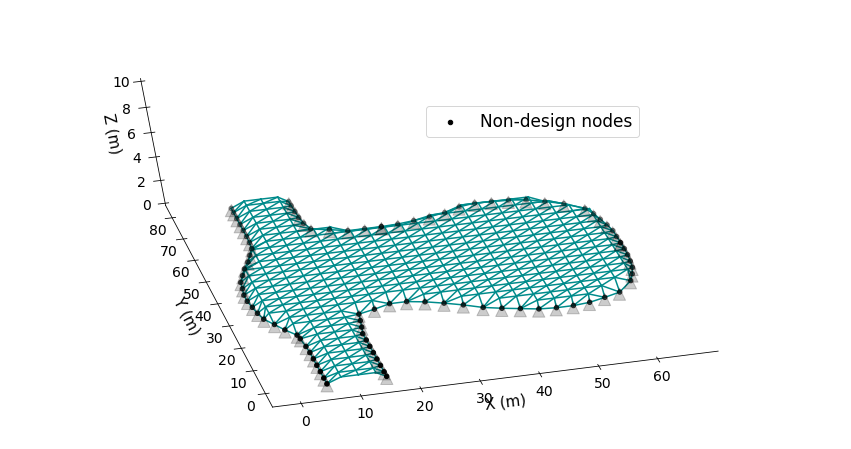

In [40]:

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(60, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Initial FEA model via PyNite

In [41]:
#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -100000/1000
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

#Build the model
model = pyn.FEModel3D() #model for FEA solving


#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):

  #Adding nodes
  model.add_node("{}".format(i),x_nodes[i],y_nodes[i],z_nodes[i])

  if i in design_nodes:
    model.add_node_load('{}'.format(i),'FZ',load,case='Case 1')
  else:
    model.def_support('{}'.format(i), True, True, True, False, False, False) #Pinned 

#Adding members
for i in range(n_ele):
  i_node = "{}".format(cnct[i,0]) #i-node of beam
  j_node = "{}".format(cnct[i,1]) #j-node of beam
  model.add_member("{}".format(i),i_node,j_node,E,G,Iy,Iz,J,A)

#Add load combo
model.add_load_combo('DEAD',{'Case 1':1})

Initial sensitivity model via JaxSSO

In [42]:
#Build the model
sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):
  #Adding nodes
  sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])

#Adding elements
for i in range(n_ele):
  i_node = cnct[i,0]
  j_node = cnct[i,1]
  sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A)

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [43]:
params_store = [] #store parameters
f_store = [] #store the functional value 
sparse = True #Store values in sparse matrix

In [44]:
def objective(x):
  params_store.append(x) #store params at each step

  #################
  #Function value#
  #################

  #Update nodes-z
  for i in range(design_nodes.shape[0]):
    model.Nodes[str(design_nodes[i])].Z = x[i] #update params in FEA model
    sens_model.nodes[design_nodes[i]].Z = x[i] #update params in SSO model
  
  #Update elements
  #In FEA model, the element is updated automatically,
  #here we only update SSO model
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) #update elements

  #FEA: solve [K]{u}={f}
  #Get {u}, displacement vector; C=0.5*{f}.T@{u}, compliance(strain energy)
  model.analyze(check_statics=False)
  u = model._D['DEAD'].reshape(-1) #displacement in 1-D vector
  C = 0.5*f@u #compliance of the system
  f_store.append(C) #store the compliance 

  ##################
  #  Gradient  #
  ##################
  #Get the sensitivity using SSO
  sens = sens_model.Sens_C_Coord(u)
  z_dof_index = design_nodes*3+2 #index indicating the z-dof
  sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization with gradient descent

In [45]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(1e-1) #step size
opt.set_GD_normalized(True) #normalize the gradients
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 3.01878485566596
Step 1, objective = 3.403306411416836
Step 2, objective = 2.95345600180093
Step 3, objective = 2.580292993173252
Step 4, objective = 2.2529636216065074
Step 5, objective = 1.9172282893078032
Step 6, objective = 1.6253060767095209
Step 7, objective = 1.3734664951586715
Step 8, objective = 1.1655376311959094
Step 9, objective = 0.9931958342670975
Step 10, objective = 0.866468050056766
Step 11, objective = 0.7497042674793621
Step 12, objective = 0.65403181530173
Step 13, objective = 0.5750096701562535
Step 14, objective = 0.5092922253794552
Step 15, objective = 0.4540495757741839
Step 16, objective = 0.40753901853534114
Step 17, objective = 0.3680864821062557
Step 18, objective = 0.3496491442737937
Step 19, objective = 0.32662434684663544
Step 20, objective = 0.31608238625020846
Step 21, objective = 0.28912689520978924
Step 22, objective = 0.27867902289422675
Step 23, objective = 0.2625791265253766
Step 24, objective = 0.25572912404630366
Step 25, obje

# Draw the final structure

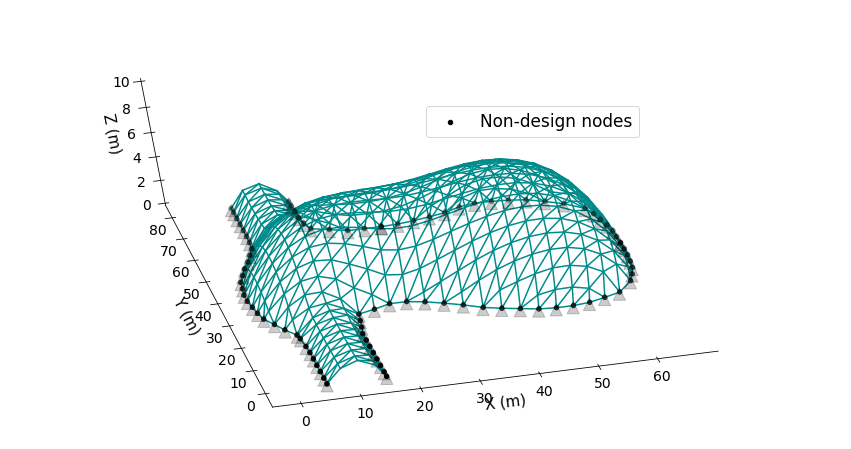

In [46]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(60, -105)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()